In [42]:
import os
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from meshplot import plot
import matplotlib.pyplot as plt
import sys 
sys.path.append('../')
import radfoam
import mesh_tools as mt
from radfoam_model.mesh_utils import marching_tetrahedra
from pytorch3d.structures import Meshes
import igl
import torch
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, RasterizationSettings,
    SoftPhongShader, PointLights, PerspectiveCameras, TexturesVertex
)

from pytorch3d.renderer import look_at_view_transform
device='cuda'
from IPython.display import clear_output


In [ ]:
### Main function

def rasterize_mesh(rasterizer, mesh, density, color):
    rast_output = rasterizer(mesh)
    bary_coords = rast_output.bary_coords
    is_non_empty = rast_output.pix_to_face!=-1
    
    # Interpolate color and density on triangle faces
    v_index = mesh.faces_packed()[rast_output.pix_to_face]
    interp_density = (density[v_index] * bary_coords.unsqueeze(-1)).sum(-2)
    interp_color = (color[v_index] * bary_coords.unsqueeze(-1)).sum(-2)

    # TODO: replace with correct integral, right now we simply compute the average
    integrated_density = (interp_density[..., :-1, :] + interp_density[..., 1:, :])/2.
    integrated_color = (interp_color[..., :-1, :] + interp_color[..., 1:, :])/2.

    # Not 100% sure about this, but it seems to work
    dists = rast_output.zbuf
    diff = dists[..., 1:]-dists[..., :-1]
    alpha_comp = 1-torch.exp(-integrated_density.squeeze()*diff)
    alpha_comp *= is_non_empty[..., 1:]
    transmittance = torch.cumprod(torch.cat((torch.ones_like(alpha_comp[..., :1]), 1-alpha_comp), dim=-1), dim=-1)
    weights = (transmittance[..., :-1] * alpha_comp)
    output_colors = (weights.unsqueeze(-1)*integrated_color).sum(-2)
    return output_colors, weights

In [44]:


# Lighting
lights = PointLights(device=device, location=[[0, 0, 3]])

# Rasterization settings
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=150
)

# Define rasterizer

# Camera setup
# Define a camera positioned at (0, 0, +3) looking towards the origin
distance = 1.5
elevation = 0    # No vertical tilt
azimuth = 0     # Rotate 30° around Y-axis
R, T = look_at_view_transform(dist=distance, elev=elevation, azim=azimuth)
cameras = PerspectiveCameras(device=device, R=R, T=T)
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)


### Pig example 

In [4]:
v, f, samples = mt.load_and_sample_shape('pig.obj', '../data/',)
queries = torch.tensor(samples, device='cuda', dtype=torch.float32) 
target_mesh = Meshes(torch.tensor(v, dtype=torch.float32, device=device)[None, :],torch.tensor(f, device=device)[None, :])
plot(v,f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0656904…

In [20]:
# Example mesh (triangle)
verts = torch.tensor(v, dtype=torch.float32).cuda()

density = 10*torch.ones_like(verts[:, :1])
color = torch.rand_like(verts)
faces = torch.tensor(f).cuda()

# Create a Meshes object
mesh = Meshes(verts=verts.unsqueeze(0), faces=faces.unsqueeze(0))

# Render the image
rast_output = rasterizer(mesh)

In [21]:
output_colors, weights = rasterize_mesh(rasterizer, mesh, density, color)

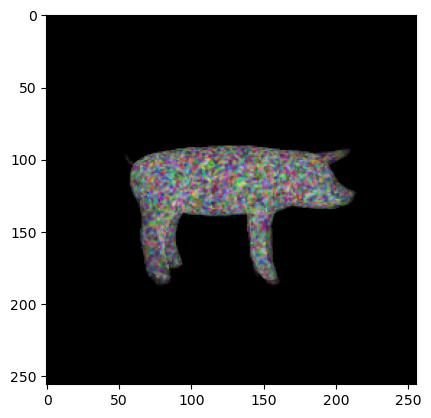

In [22]:
plt.imshow(output_colors.squeeze().cpu().detach().numpy())

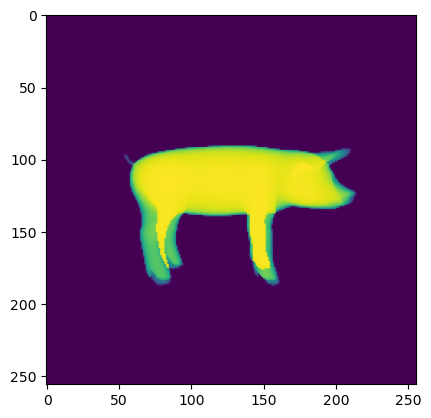

In [23]:
plt.imshow(weights.sum(-1).squeeze().cpu().detach().numpy())

### Adapted to our settings


In [45]:
num_init_points = 3000
SIZE = 64
primal_points = (torch.rand(num_init_points, 3, device='cuda')-.5)*1.5
primal_color = torch.rand_like(primal_points)
primal_density = 1*torch.ones_like(primal_points[:, :1])

triangulation = radfoam.Triangulation(primal_points)
perm = triangulation.permutation().to(torch.long)
primal_points = primal_points[perm]
primal_color = primal_color[perm]
primal_density = primal_density[perm]

primal_points.requires_grad_(True)
primal_color.requires_grad_(True)
primal_density.requires_grad_(True)
print('ok')

ok


In [46]:
def random_rast():
    distance = 1.5
    elevation = np.random.randint(0, 360)    # No vertical tilt
    azimuth = np.random.randint(0, 360)     # Rotate 30° around Y-axis
    R, T = look_at_view_transform(dist=distance, elev=elevation, azim=azimuth)
    cameras = PerspectiveCameras(device=device, R=R, T=T)
    
    raster_settings = RasterizationSettings(
    image_size=SIZE,
    blur_radius=0.0,
    faces_per_pixel=150
    )


    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
    return rasterizer

In [47]:
def tet_to_tri(tets):
    return torch.cat((tets[:, [0, 2, 1]], tets[:, [0, 1, 3]], tets[:, [0, 3, 2]], tets[:, [2, 3, 1]]), dim=0)

In [48]:
faces = tet_to_tri(triangulation.tets().long())
mesh = Meshes(verts=primal_points.unsqueeze(0), faces=faces.unsqueeze(0))

In [49]:
output_colors, weights = rasterize_mesh(rasterizer, mesh, primal_density, primal_color)

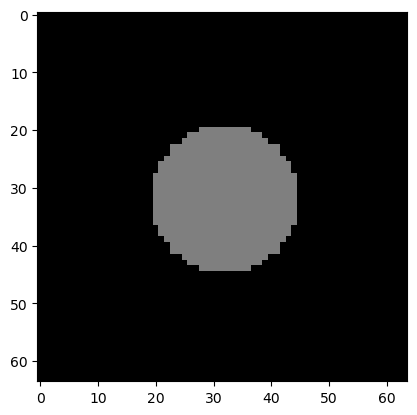

In [50]:
# Create a black image
image_size = SIZE
image = np.zeros((image_size, image_size))
# Define the circle parameters
center = (image_size // 2, image_size // 2)
radius = image_size *0.2
# Draw the white circle
y, x = np.ogrid[:image_size, :image_size]
mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
image[mask] = .5
circle_image = torch.tensor(image, dtype=torch.float32).cuda()[None, ..., None].repeat(1, 1, 1, 3)

# Display the image
plt.imshow(circle_image.squeeze().cpu().detach().numpy(), cmap='gray')

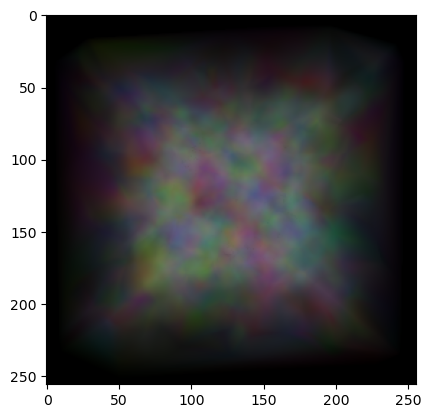

In [51]:
output_colors, weights = rasterize_mesh(rasterizer, mesh, primal_density, primal_color)
plt.imshow(output_colors.squeeze().cpu().detach().numpy())

In [52]:
from IPython.display import clear_output

L = []

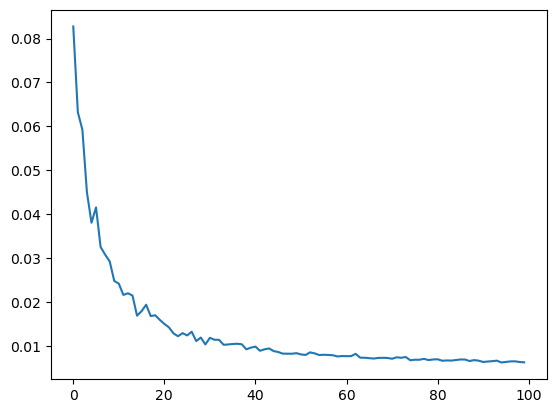

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


In [53]:
# training density and colors
rast = random_rast()
optimizer = torch.optim.SGD([primal_color, primal_density], lr=1000)
for i in tqdm(range(100)):
    optimizer.zero_grad()
    loss=0 
    for i in range(3):
        rast = random_rast()
        output_colors, _ = rasterize_mesh(rast, mesh, primal_density, primal_color)
        loss += ((output_colors-circle_image)**2).mean()
    # loss += 1e-2*(primal_density**2).mean()
    L.append(loss.item())
    clear_output(wait=True)
    plt.plot(L)
    plt.show()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        primal_density.clamp_(0, 10000)
        primal_color.clamp_(0, 1)

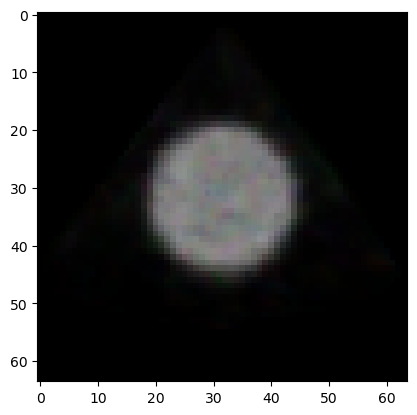

In [54]:
output_colors, weights = rasterize_mesh(rast, mesh, (primal_density), (primal_color))
plt.imshow(output_colors.squeeze().cpu().detach().numpy())

In [55]:
(primal_density.max()+primal_density.min())/2.

tensor(1.3095, device='cuda:0', grad_fn=<DivBackward0>)

In [56]:
thresh = (primal_density.max()+primal_density.min())/2.
thresh

tensor(1.3095, device='cuda:0', grad_fn=<DivBackward0>)

In [57]:
v, f, feat = marching_tetrahedra(triangulation.tets().long(), primal_density.squeeze()-thresh, primal_points, primal_color)
plot(v.cpu().detach().numpy(), f.cpu().detach().numpy(), feat.cpu().detach().numpy())
mt.export_obj(v.cpu().detach().numpy(), f.cpu().detach().numpy(), 'ball_1.obj')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0042072…

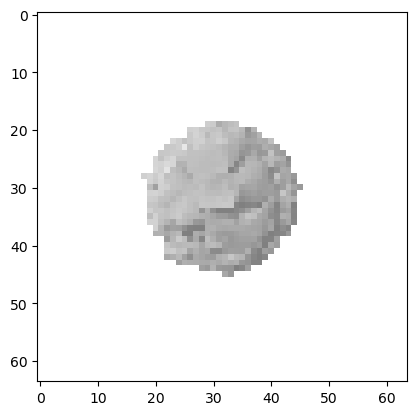

In [58]:
lights = PointLights(device=device, location=[[0, 0, 3]])

# Define shader (Phong shading)
shader = SoftPhongShader(device=device, cameras=cameras, lights=lights)

# Create the MeshRenderer
renderer = MeshRenderer(rasterizer=rast, shader=shader)
textures = TexturesVertex(verts_features=torch.ones_like(v.unsqueeze(0)))  # White color

images = renderer(Meshes(v.unsqueeze(0), f.unsqueeze(0), textures=textures))

plt.imshow(images.squeeze().cpu().detach().numpy())


In [59]:

# Define shader (Phong shading)
shader = SoftPhongShader(device=device, cameras=cameras, lights=lights)

# Create the MeshRenderer
renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)


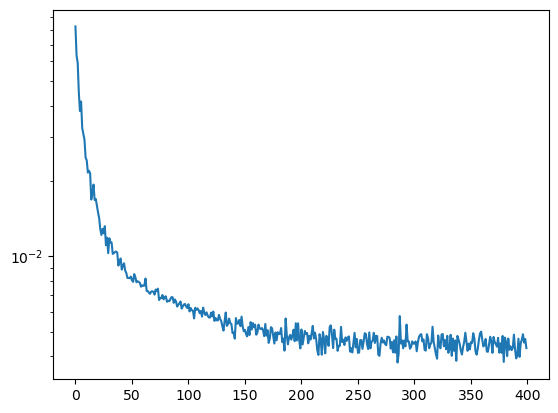

100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


In [ ]:
# training positions aswell
optimizer = torch.optim.SGD([primal_points], lr=10)
for i in tqdm(range(100)):
    optimizer.zero_grad()
    loss=0 
    for i in range(3):
        rast = random_rast()
        output_colors, _ = rasterize_mesh(rast, mesh, primal_density, primal_color)
        loss += ((output_colors-circle_image)**2).mean()
    # loss += 1e-2*(primal_density**2).mean()
    L.append(loss.item())
    clear_output(wait=True)
    plt.plot(L)
    plt.yscale('log')
    plt.show()
    loss.backward()
    optimizer.step()

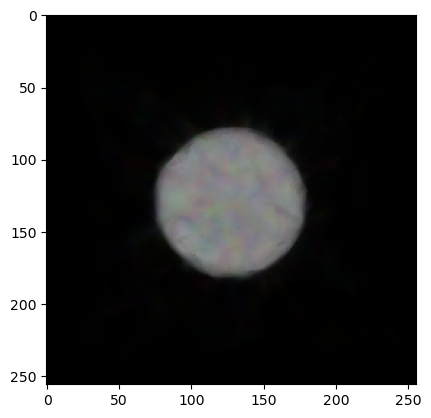

In [65]:
output_colors, weights = rasterize_mesh(rasterizer, mesh, primal_density, primal_color)
plt.imshow(output_colors.squeeze().cpu().detach().numpy())

In [66]:
v, f, feat = marching_tetrahedra(triangulation.tets().long(), primal_density.squeeze()-thresh, primal_points, primal_color)
plot(v.cpu().detach().numpy(), f.cpu().detach().numpy(), feat.cpu().detach().numpy())
mt.export_obj(v.cpu().detach().numpy(), f.cpu().detach().numpy(), 'ball_2.obj')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000397…

In [63]:
v, f, feat, edge = marching_tetrahedra(triangulation.tets().long(), primal_density.squeeze()-thresh, primal_points, primal_color, True)
